<h1>Simple Amplitude Adder</h1>

In [29]:
# kernel extension for conditional cell execution
#
# set skip to True (%%skip True) in any block you want to skip

%reload_ext skip_extension

<h2>Step 0. Obtain the API_KEY from the .env file</h2>

In [30]:
from environs import Env
from IPython.display import display, Markdown

env = Env()

#env.read_env()                         # this does not work (?)
env.read_env('.env', recurse=False)     # read .env file, if it exists

token = env('IBM_QUANTUM_TOKEN')  

display(Markdown('<span style="color:red">>>> Token: ' + token[:5] + '...</span>'))     # Check that the starting characters of the token are printed

<span style="color:red">>>> Token: eajHh...</span>

<h2>Step 1.1. Create a Draper QFT Adder circuit</h2>

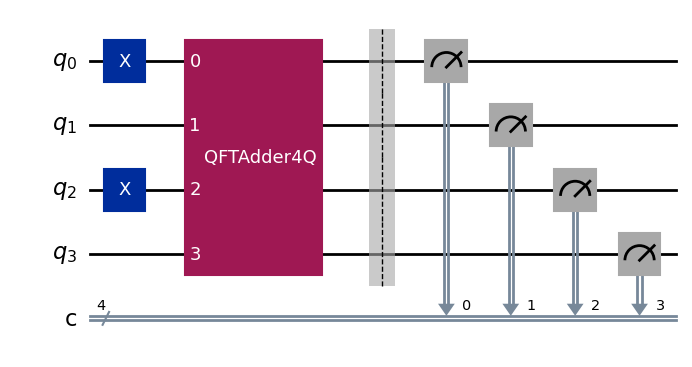

In [37]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

def DraperQFTAdder4Q() :
  qasm = """
    OPENQASM 2.0;
    include "qelib1.inc";

    gate qft4Q a, b, c, d {
      h d;
      cp(pi / 2) c, d;
      cp(pi / 4) b, d;
      cp(pi / 8) a, d;
      h c;
      cp(pi / 2) b, c;
      cp(pi / 4) a, c;
      h b;
      cp(pi / 2) a, b;
      h a;
      swap b, c;
      swap a, d;
    }

    gate inv_qft4Q a, b, c, d {
      swap a, d;
      swap b, c;
      h a;
      cp(-pi / 2) b, a;
      cp(-pi / 4) c, a;
      cp(-pi / 8) d, a;
      h b;
      cp(-pi / 2) c, b;
      cp(-pi / 4) d, b;
      h c;
      cp(-pi / 2) d, c;
      h d;
    }

    gate draperQFTAdder4Q a, b, c, d {
      qft4Q a, b, c, d;
      barrier a, b, c, d;
      p(pi / 8) a;
      t b;
      s c;
      z d;
      barrier a, b, c, d;
      inv_qft4Q a, b, c, d;
    }

    qreg a[4];

    draperQFTAdder4Q a[0], a[1], a[2], a[3];
   
    """
  qftAdder4Q = QuantumCircuit.to_gate(QuantumCircuit.from_qasm_str(qasm))

  qftAdder4Q.name = 'QFTAdder4Q'

  return qftAdder4Q

qreg_q = QuantumRegister(4, 'q')
creg_c = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

# Input: qubits 0 and 1 in superposition
# circuit.h(qreg_q[0])
# circuit.h(qreg_q[1])

# Alternative input: 0110 (6)
circuit.x(qreg_q[1])
circuit.x(qreg_q[2])

circuit.append(DraperQFTAdder4Q(), [qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3]])

circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

circuit.measure(qreg_q[0], creg_c[0])
circuit.measure(qreg_q[1], creg_c[1])
circuit.measure(qreg_q[2], creg_c[2])
circuit.measure(qreg_q[3], creg_c[3])

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
circuit.draw("mpl")

<h2>Step 2.1.a. Set up backend for simulation</h2>

In [38]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

backend = FakeAlmadenV2()

<h2>Step 2.1.b. Alternatively set up backend for hardware QPU</h2>

In [12]:
%%skip False      # set to True/False in order to skip/run this cell

display(Markdown('## <span style="color:red">>>>WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>'))

from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService(channel="ibm_quantum_platform", token=token)

backend = service.least_busy(simulator=False, operational=True)

## <span style="color:red">>>>WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>

qiskit_runtime_service._discover_account:WARNING:2026-01-19 22:50:37,662: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-01-19 22:50:43,942: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-01-19 22:50:44,486: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-01-19 22:50:46,593: Using instance: open-instance, plan: open


<h2>Step 2.2. Convert to an ISA circuit layout</h2> 
<h3>(either for simulation or running on hardware QPU)</h3>

In [39]:
# Convert to an ISA circuit layout

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

display(Markdown('<span style="color:red">>>> Execution backend: ' + backend.name + '</span>'))

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw('mpl', idle_wires=False)


<span style="color:red">>>> Execution backend: fake_almaden</span>

TranspilerError: 'HighLevelSynthesis is unable to synthesize "measure"'

<h2>Step 3.a. Simulate the circuit</h2>

In [40]:

job = backend.run([isa_circuit], shots=5000)

# backend run deprecated. Substitute by:
# (but it didn't work properly for simulation, only for QPU execution)
# from qiskit_ibm_runtime import SamplerV2 as Sampler
# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit],shots=1000)

# Use the job ID to retrieve your job data later

job_id = job.job_id()

display(Markdown('<span style="color:red">>>> Save the job id for accessing the results when finished:<br>' +
                                         '>>> Job ID: ' + job_id + ' (' + str(job.status()) + ')</span>' ))


<span style="color:red">>>> Save the job id for accessing the results when finished:<br>>>> Job ID: 710cc593-ffb3-48da-9c5c-cb24a1009b13 (JobStatus.INITIALIZING)</span>

<h2>Step 3.b. Run the circuit on hardware QPU</h2>

In [20]:
%%skip False      # set to True/False in order to skip/run this cell

# job = backend.run([isa_circuit], shots=5000)
# backend run deprecated. Substitute by:

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit],shots=10000)

# Use the job ID to retrieve your job data later

job_id = job.job_id()

display(Markdown('<span style="color:red">>>> Save the job id for accessing the results when finished:<br>' +
                                         '>>> Job ID: ' + job_id + ' (' + str(job.status()) + ')</span>' ))


<span style="color:red">>>> Save the job id for accessing the results when finished:<br>>>> Job ID: d5nahdph2mqc739bplkg (QUEUED)</span>

<h2>Step 4.1'.a. Access the results</h2>
<h3> (only for simulation)</h3>

In [41]:

# In order to fully recover your Job object, you need the job id.
# When the job is done, you can recover the Job object like this:

# Job for which we are showing the results.

display(Markdown('<span style="color:red">>>> Job ID: ' + job_id + ' (' + str(job.status()) + ')</span>'))

# Get results for the first (and only) PUB

result = job.result()

counts = result.get_counts()

display(Markdown('<span style="color:red">>>> Job results: ' + str(counts) + '</span>' ))


<span style="color:red">>>> Job ID: 710cc593-ffb3-48da-9c5c-cb24a1009b13 (JobStatus.DONE)</span>

<span style="color:red">>>> Job results: {'0111': 5000}</span>

<h2>Step 4.1'.b. Access the results of a previously executed job</h2>
<h3>(only for execution on hardware QPU)</h3>

In [21]:
#%%skip False

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum_platform", token=token)

# In order to fully recover your Job object, you need the job id.
# When the job is done, you can recover the Job object like this:

job_id = 'd5nahdph2mqc739bplkg'      # execution on QPU (19/01/26); with q0 and q1 in superposition (10000 runs)
       # 'd5naens8d8hc73chhdng'      # execution on QPU (19/01/26); with q0 and q1 in superposition (1000 runs)

job = service.job(job_id)

# Job for which we are showing the results.

display(Markdown('<span style="color:red">>>> Job ID: ' + job_id + '</span>'))

# Get results for the first (and only) PUB

counts = job.result()[0].data.c.get_counts()     # if this does not work, check in the dashboard the instructions  
                                                 # for accessing the results of this particular task

display(Markdown('<span style="color:red">>>> Job counts: ' + str(counts) + '</span>' ))


qiskit_runtime_service._discover_account:WARNING:2026-01-19 22:58:52,013: Loading account with the given token. A saved account will not be used.
qiskit_runtime_service.__init__:WARNING:2026-01-19 22:58:58,369: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


<span style="color:red">>>> Job ID: d5nahdph2mqc739bplkg</span>

<span style="color:red">>>> Job counts: {'1011': 837, '0111': 5618, '1111': 640, '0011': 964, '1001': 255, '0101': 444, '1100': 80, '0100': 92, '1000': 95, '0010': 84, '0110': 232, '1101': 175, '1110': 133, '0001': 185, '1010': 88, '0000': 78}</span>

<h2>Step 4.2. Plot the results</h2>

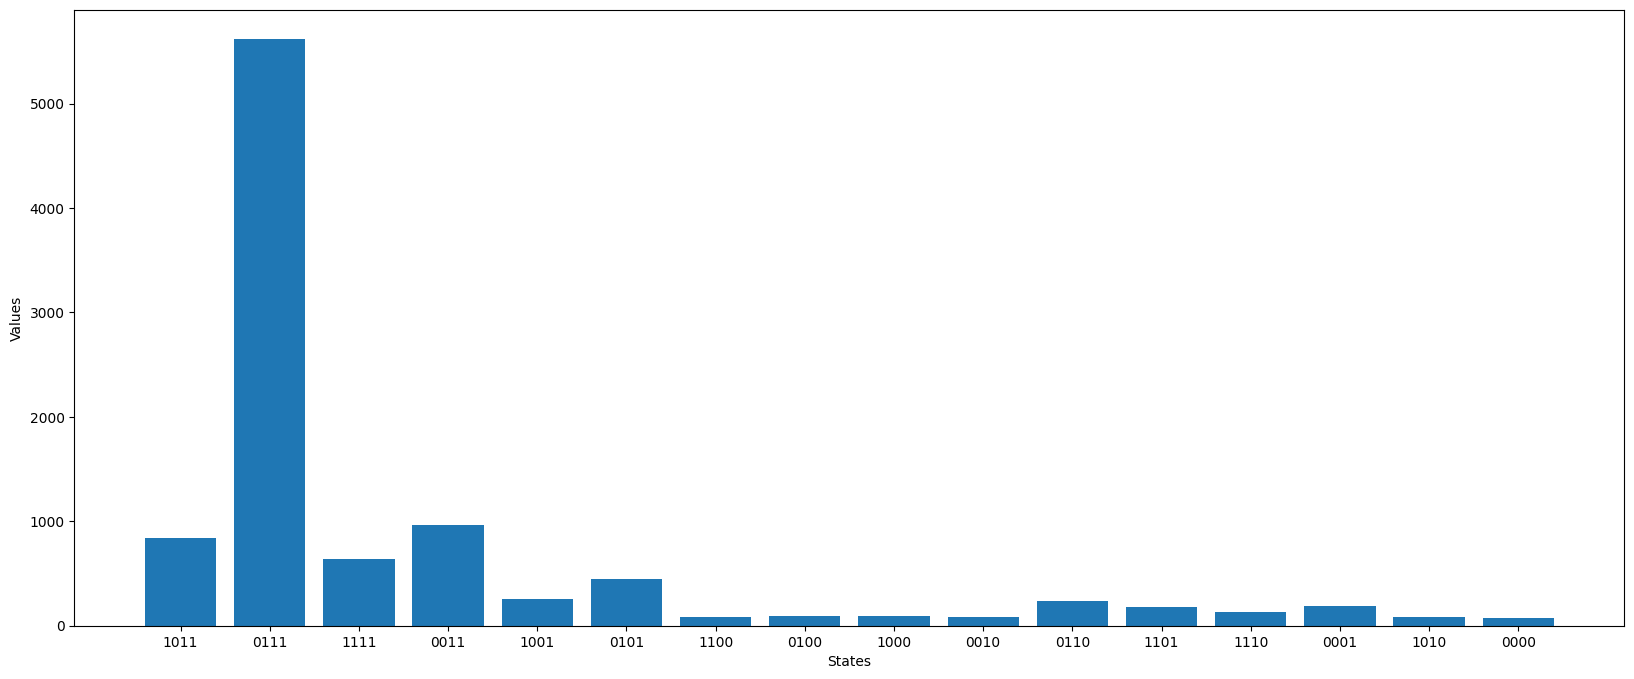

<span style="color:red">>>> Results for job ID: d5nahdph2mqc739bplkg</span>

In [22]:

# Plot the results
 
from matplotlib import pyplot as plt

# plotting graph of values

plt.rcParams["figure.figsize"] = (20,8)
plt.bar(counts.keys(), counts.values())
plt.xlabel('States')
plt.ylabel('Values')

plt.show()

display(Markdown('<span style="color:red">>>> Results for job ID: ' + job_id + '</span>'))